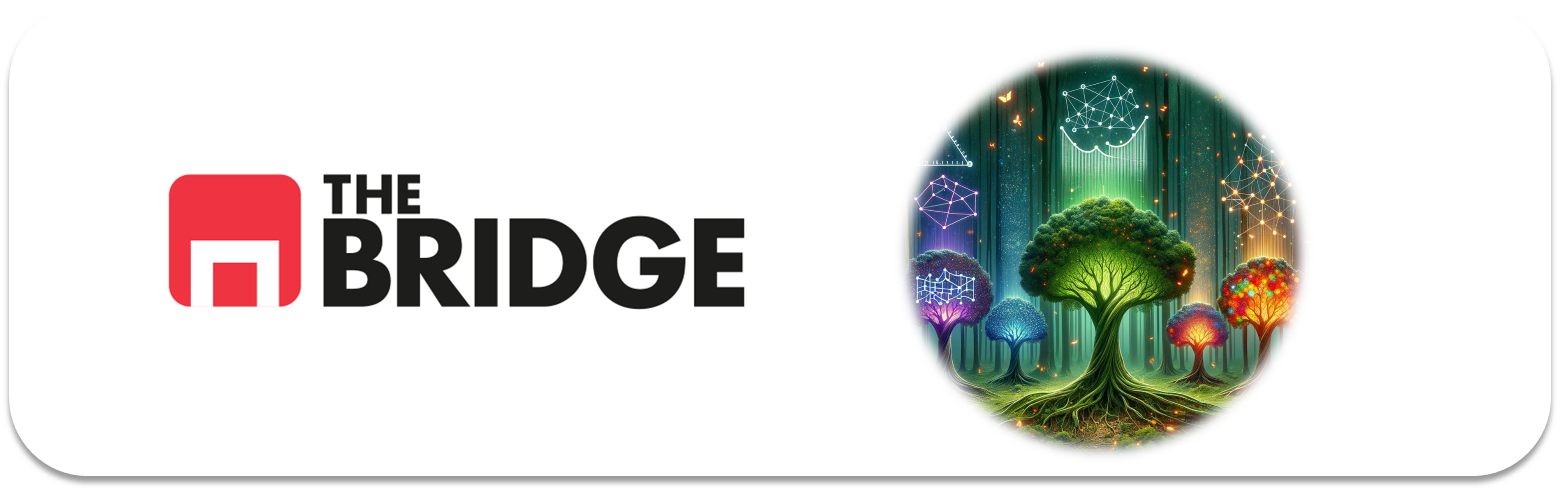

## PRACTICA OBLIGATORIA: **Arboles de Decisión y Ajuste de hiperparámetros**

* La práctica obligatoria de esta unidad consiste en encontrar el mejor modelo para resolver un problema de predicción de si los destinatarios de una campaña de marketing adquirirán un producto concreto. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from pprint import pprint

from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression

from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

from sklearn.model_selection import train_test_split

from sklearn.metrics import classification_report

from EDA_function_tools import *

### Descripción

En el directorio data encontrarás un dataset que contiene datos relacionados con campañas de marketing directo de una institución bancaria portuguesa (es el dataset "Bank Marketing" de la UCI Machine Learning Repository). Los datos se recopilaron de campañas de marketing telefónico, donde el objetivo principal era predecir si el cliente se suscribiría a un depósito a plazo.

La práctica consiste en completar el proceso de creación de un modelo basado en árboles de decisión que permita predecir si un cliente (dadas unas características similares a las del dataset) "comprará" el depósito a plazo. Sigue los pasos necesarios de un proceso de ML para crear el modelo, optimizar sus hiperparámetros, comparar los resultados de esa optimización con una regresión logística (sin optimizar, con sus hiperparámetros por defecto) y finalmente evaluarlo contra test y hacer una pequeña valoración del resultado obtenido.

Tendrás que hacer la limpieza, split, minieda, selección, tratamiento, primeros entrenamientos, optimización, comparación y evaluación según tu mejor criterio. Eso sí, es obligatorio:
- Identificar el target y analizar su distribución
- Realizar una optimización de hiperparámetros, escogiendo un grid medianemante razonado
- Comparar con el modelo baseline
- Evaluar contra test

AYUDA: La dirección del banco nos proporciona estas notas (en inglés):

 
   **bank client data:**  
   1 - age (numeric)  
   2 - job : type of job (categorical: "admin.","unknown","unemployed","management","housemaid","entrepreneur","student",
                                       "blue-collar","self-employed","retired","technician","services")   
   3 - marital : marital status (categorical: "married","divorced","single"; note: "divorced" means divorced or widowed)  
   4 - education (categorical: "unknown","secondary","primary","tertiary")  
   5 - default: has credit in default? (binary: "yes","no")  
   6 - balance: average yearly balance, in euros (numeric)   
   7 - housing: has housing loan? (binary: "yes","no")  
   8 - loan: has personal loan? (binary: "yes","no")   

   **related with the last contact of the current campaign:**  
   9 - contact: contact communication type (categorical: "unknown","telephone","cellular")   
  10 - day: last contact day of the month (numeric)  
  11 - month: last contact month of year (categorical: "jan", "feb", "mar", ..., "nov", "dec")  
  12 - duration: last contact duration, in seconds (numeric)    

   **other attributes:**  
  13 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)  
  14 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric, -1 means client was not previously contacted)  
  15 - previous: number of contacts performed before this campaign and for this client (numeric)  
  16 - poutcome: outcome of the previous marketing campaign (categorical: "unknown","other","failure","success")

  

In [2]:
dic = {
    'age': 'edad (numérico)',
    'job': 'tipo de trabajo (categórico: "administrativo", "desconocido", "desempleado", "gerencia", "ama de casa", "emprendedor", "estudiante", "trabajador de cuello azul", "autónomo", "jubilado", "técnico", "servicios")',
    'marital': 'estado civil (categórico: "casado", "divorciado", "soltero"; nota: "divorciado" significa divorciado o viudo)',
    'education': 'educación (categórico: "desconocido", "secundaria", "primaria", "terciaria")',
    'default': '¿tiene crédito en mora? (binario: "sí", "no")',
    'balance': 'saldo medio anual, en euros (numérico)',
    'housing': '¿tiene préstamo hipotecario? (binario: "sí", "no")',
    'loan': '¿tiene préstamo personal? (binario: "sí", "no")',
    'contact': 'tipo de comunicación de contacto (categórico: "desconocido", "teléfono", "celular")',
    'day': 'día del último contacto del mes (numérico)',
    'month': 'mes del último contacto del año (categórico: "ene", "feb", "mar", ..., "nov", "dic")',
    'duration': 'duración del último contacto, en segundos (numérico)',
    'campaign': 'número de contactos realizados durante esta campaña y para este cliente (numérico, incluye el último contacto)',
    'pdays': 'número de días transcurridos desde el último contacto con el cliente en una campaña anterior (numérico, -1 significa que el cliente no fue contactado previamente)',
    'previous': 'número de contactos realizados antes de esta campaña y para este cliente (numérico)',
    'poutcome': 'resultado de la campaña de marketing anterior (categórico: "desconocido", "otro", "fracaso", "éxito")'
}

## Importación datos

In [3]:
df = pd.read_csv('./data/bank-full.csv',sep=';')
df.head(8)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no
5,35,management,married,tertiary,no,231,yes,no,unknown,5,may,139,1,-1,0,unknown,no
6,28,management,single,tertiary,no,447,yes,yes,unknown,5,may,217,1,-1,0,unknown,no
7,42,entrepreneur,divorced,tertiary,yes,2,yes,no,unknown,5,may,380,1,-1,0,unknown,no


In [4]:
df.shape

(45211, 17)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


Problema de clasificación: modelo de regresión logística o albol de decisión para clasificación

## Variable target

<Axes: >

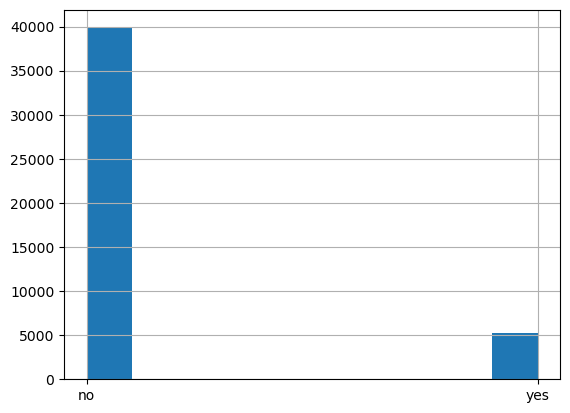

In [6]:
df.y.hist()

In [7]:
df.y.value_counts(normalize=True)

y
no     0.883015
yes    0.116985
Name: proportion, dtype: float64

Ojo!!! Que tiene un % muy alto de no.

## Limpieza y tratamiento datos

In [8]:
df.isna().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

No hay nulos

In [9]:
df.duplicated().sum()

0

No hay duplicados

In [10]:
dic

{'age': 'edad (numérico)',
 'job': 'tipo de trabajo (categórico: "administrativo", "desconocido", "desempleado", "gerencia", "ama de casa", "emprendedor", "estudiante", "trabajador de cuello azul", "autónomo", "jubilado", "técnico", "servicios")',
 'marital': 'estado civil (categórico: "casado", "divorciado", "soltero"; nota: "divorciado" significa divorciado o viudo)',
 'education': 'educación (categórico: "desconocido", "secundaria", "primaria", "terciaria")',
 'default': '¿tiene crédito en mora? (binario: "sí", "no")',
 'balance': 'saldo medio anual, en euros (numérico)',
 'housing': '¿tiene préstamo hipotecario? (binario: "sí", "no")',
 'loan': '¿tiene préstamo personal? (binario: "sí", "no")',
 'contact': 'tipo de comunicación de contacto (categórico: "desconocido", "teléfono", "celular")',
 'day': 'día del último contacto del mes (numérico)',
 'month': 'mes del último contacto del año (categórico: "ene", "feb", "mar", ..., "nov", "dic")',
 'duration': 'duración del último contact

## Separación Train/ Test

In [11]:
train_set, test_set = train_test_split(df, test_size=0.20, random_state=42, stratify= df['y'])
print(len(train_set))
print(len(test_set))

36168
9043


In [12]:
train_set['y_numeric'] = train_set['y'].map({'no': 0, 'yes': 1})

## Lista de columnas

In [13]:
features_num = train_set.select_dtypes(['int','float']).columns.tolist()
features_cat = train_set.select_dtypes(['object','category']).columns.tolist()
print(features_num)
print(features_cat)

['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous', 'y_numeric']
['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome', 'y']


## Mini EDA

### Univariable

#### Numéricas

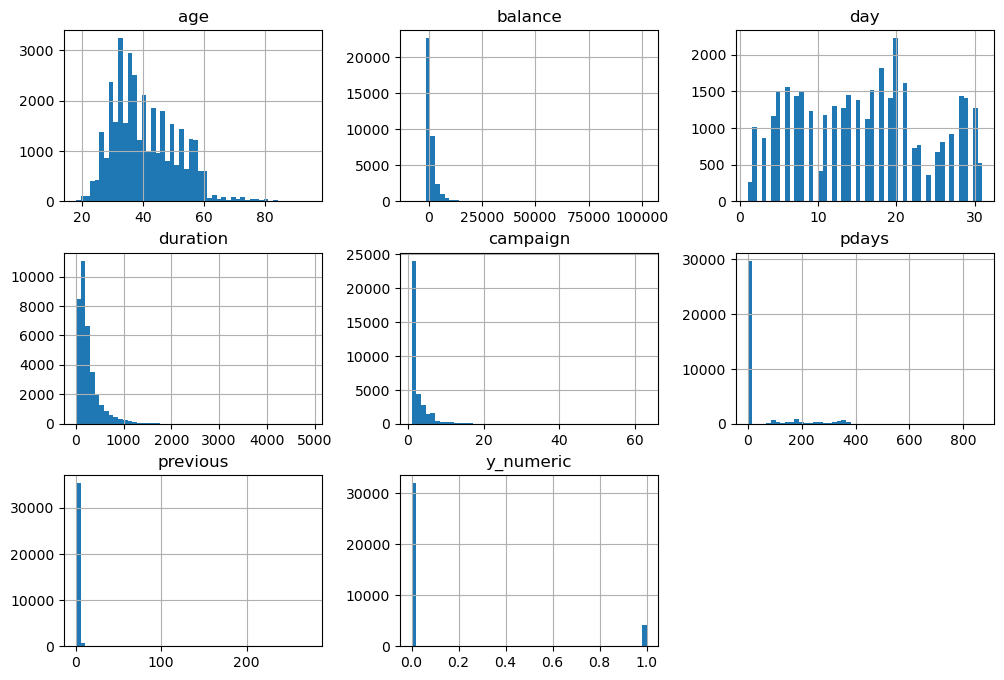

In [14]:
train_set.hist(bins=50, figsize=(12, 8)) 
plt.show()

In [15]:
train_set.describe().round(3)

,age,balance,day,duration,campaign,pdays,previous,y_numeric
count,36168.000,36168.000,36168.000,36168.000,36168.000,36168.000,36168.000,36168.000
mean,40.893,1365.493,15.818,258.507,2.764,40.157,0.582,0.117
std,10.627,3068.544,8.332,259.142,3.104,100.163,2.409,0.321
min,18.000,-8019.000,1.000,0.000,1.000,-1.000,0.000,0.000
25%,33.000,74.000,8.000,103.000,1.000,-1.000,0.000,0.000
50%,39.000,451.000,16.000,180.000,2.000,-1.000,0.000,0.000
75%,48.000,1430.250,21.000,318.000,3.000,-1.000,0.000,0.000
max,95.000,102127.000,31.000,4918.000,63.000,871.000,275.000,1.000


In [16]:
for columna in features_num:
    counts = train_set[columna]
    top_values = counts.nlargest(5)
    print(f'Para {columna}, los 5 mayores valores son:\n{top_values}')
    for value in top_values:
        cantidad = train_set[train_set[columna] == value].shape[0]/len(train_set)*100
        print(f'{value} en %: {cantidad:.2f} en cantidad {train_set[train_set[columna] == value].shape[0]}')
    print('*************')
    print()

Para age, los 5 mayores valores son:
33699    95
41663    95
31233    94
44262    93
42727    92
Name: age, dtype: int64
95 en %: 0.01 en cantidad 2
95 en %: 0.01 en cantidad 2
94 en %: 0.00 en cantidad 1
93 en %: 0.00 en cantidad 1
92 en %: 0.00 en cantidad 1
*************

Para balance, los 5 mayores valores son:
39989    102127
42558     81204
43393     81204
41693     71188
19785     66721
Name: balance, dtype: int64
102127 en %: 0.00 en cantidad 1
81204 en %: 0.01 en cantidad 2
81204 en %: 0.01 en cantidad 2
71188 en %: 0.00 en cantidad 1
66721 en %: 0.00 en cantidad 1
*************

Para day, los 5 mayores valores son:
18810    31
18499    31
18544    31
18788    31
18743    31
Name: day, dtype: int64
31 en %: 1.45 en cantidad 525
31 en %: 1.45 en cantidad 525
31 en %: 1.45 en cantidad 525
31 en %: 1.45 en cantidad 525
31 en %: 1.45 en cantidad 525
*************

Para duration, los 5 mayores valores son:
24148    4918
9947     3881
44602    3785
19639    3422
2386     3366
Name: 

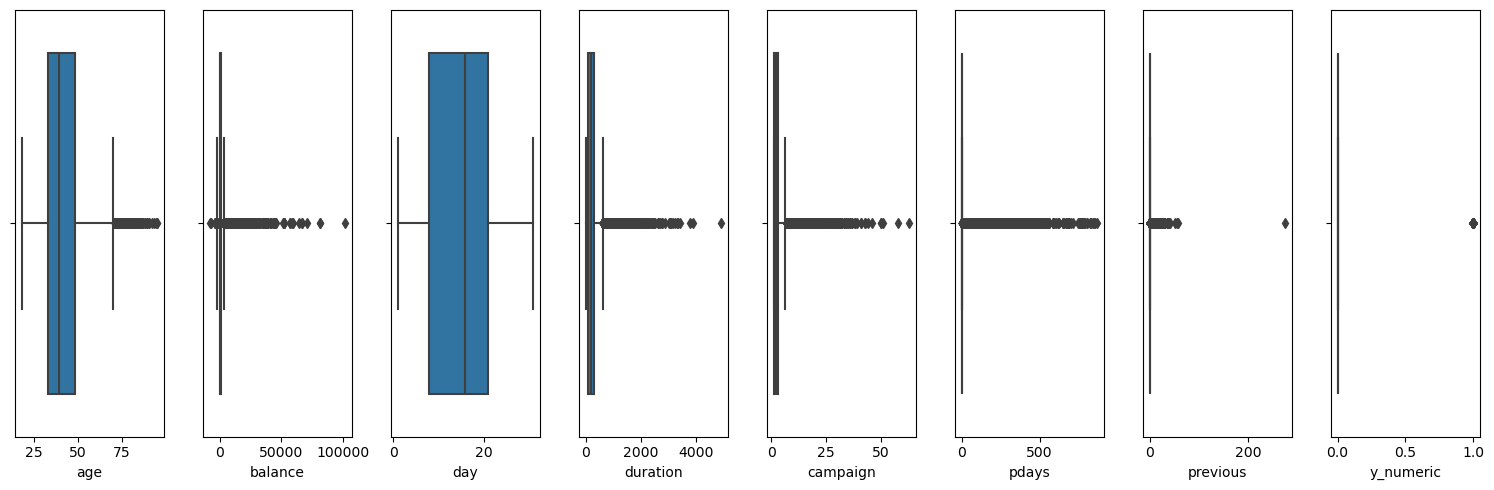

In [17]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=1, ncols=len(features_num), figsize=(15, 5))

for i, columna in enumerate(features_num):
    sns.boxplot(x=train_set[columna], ax=axes[i])

plt.tight_layout()
plt.show()

EStoy por cargarme el outlier de la variable previous, pero voy a esperar al análisis bivariante.

#### Categóricas

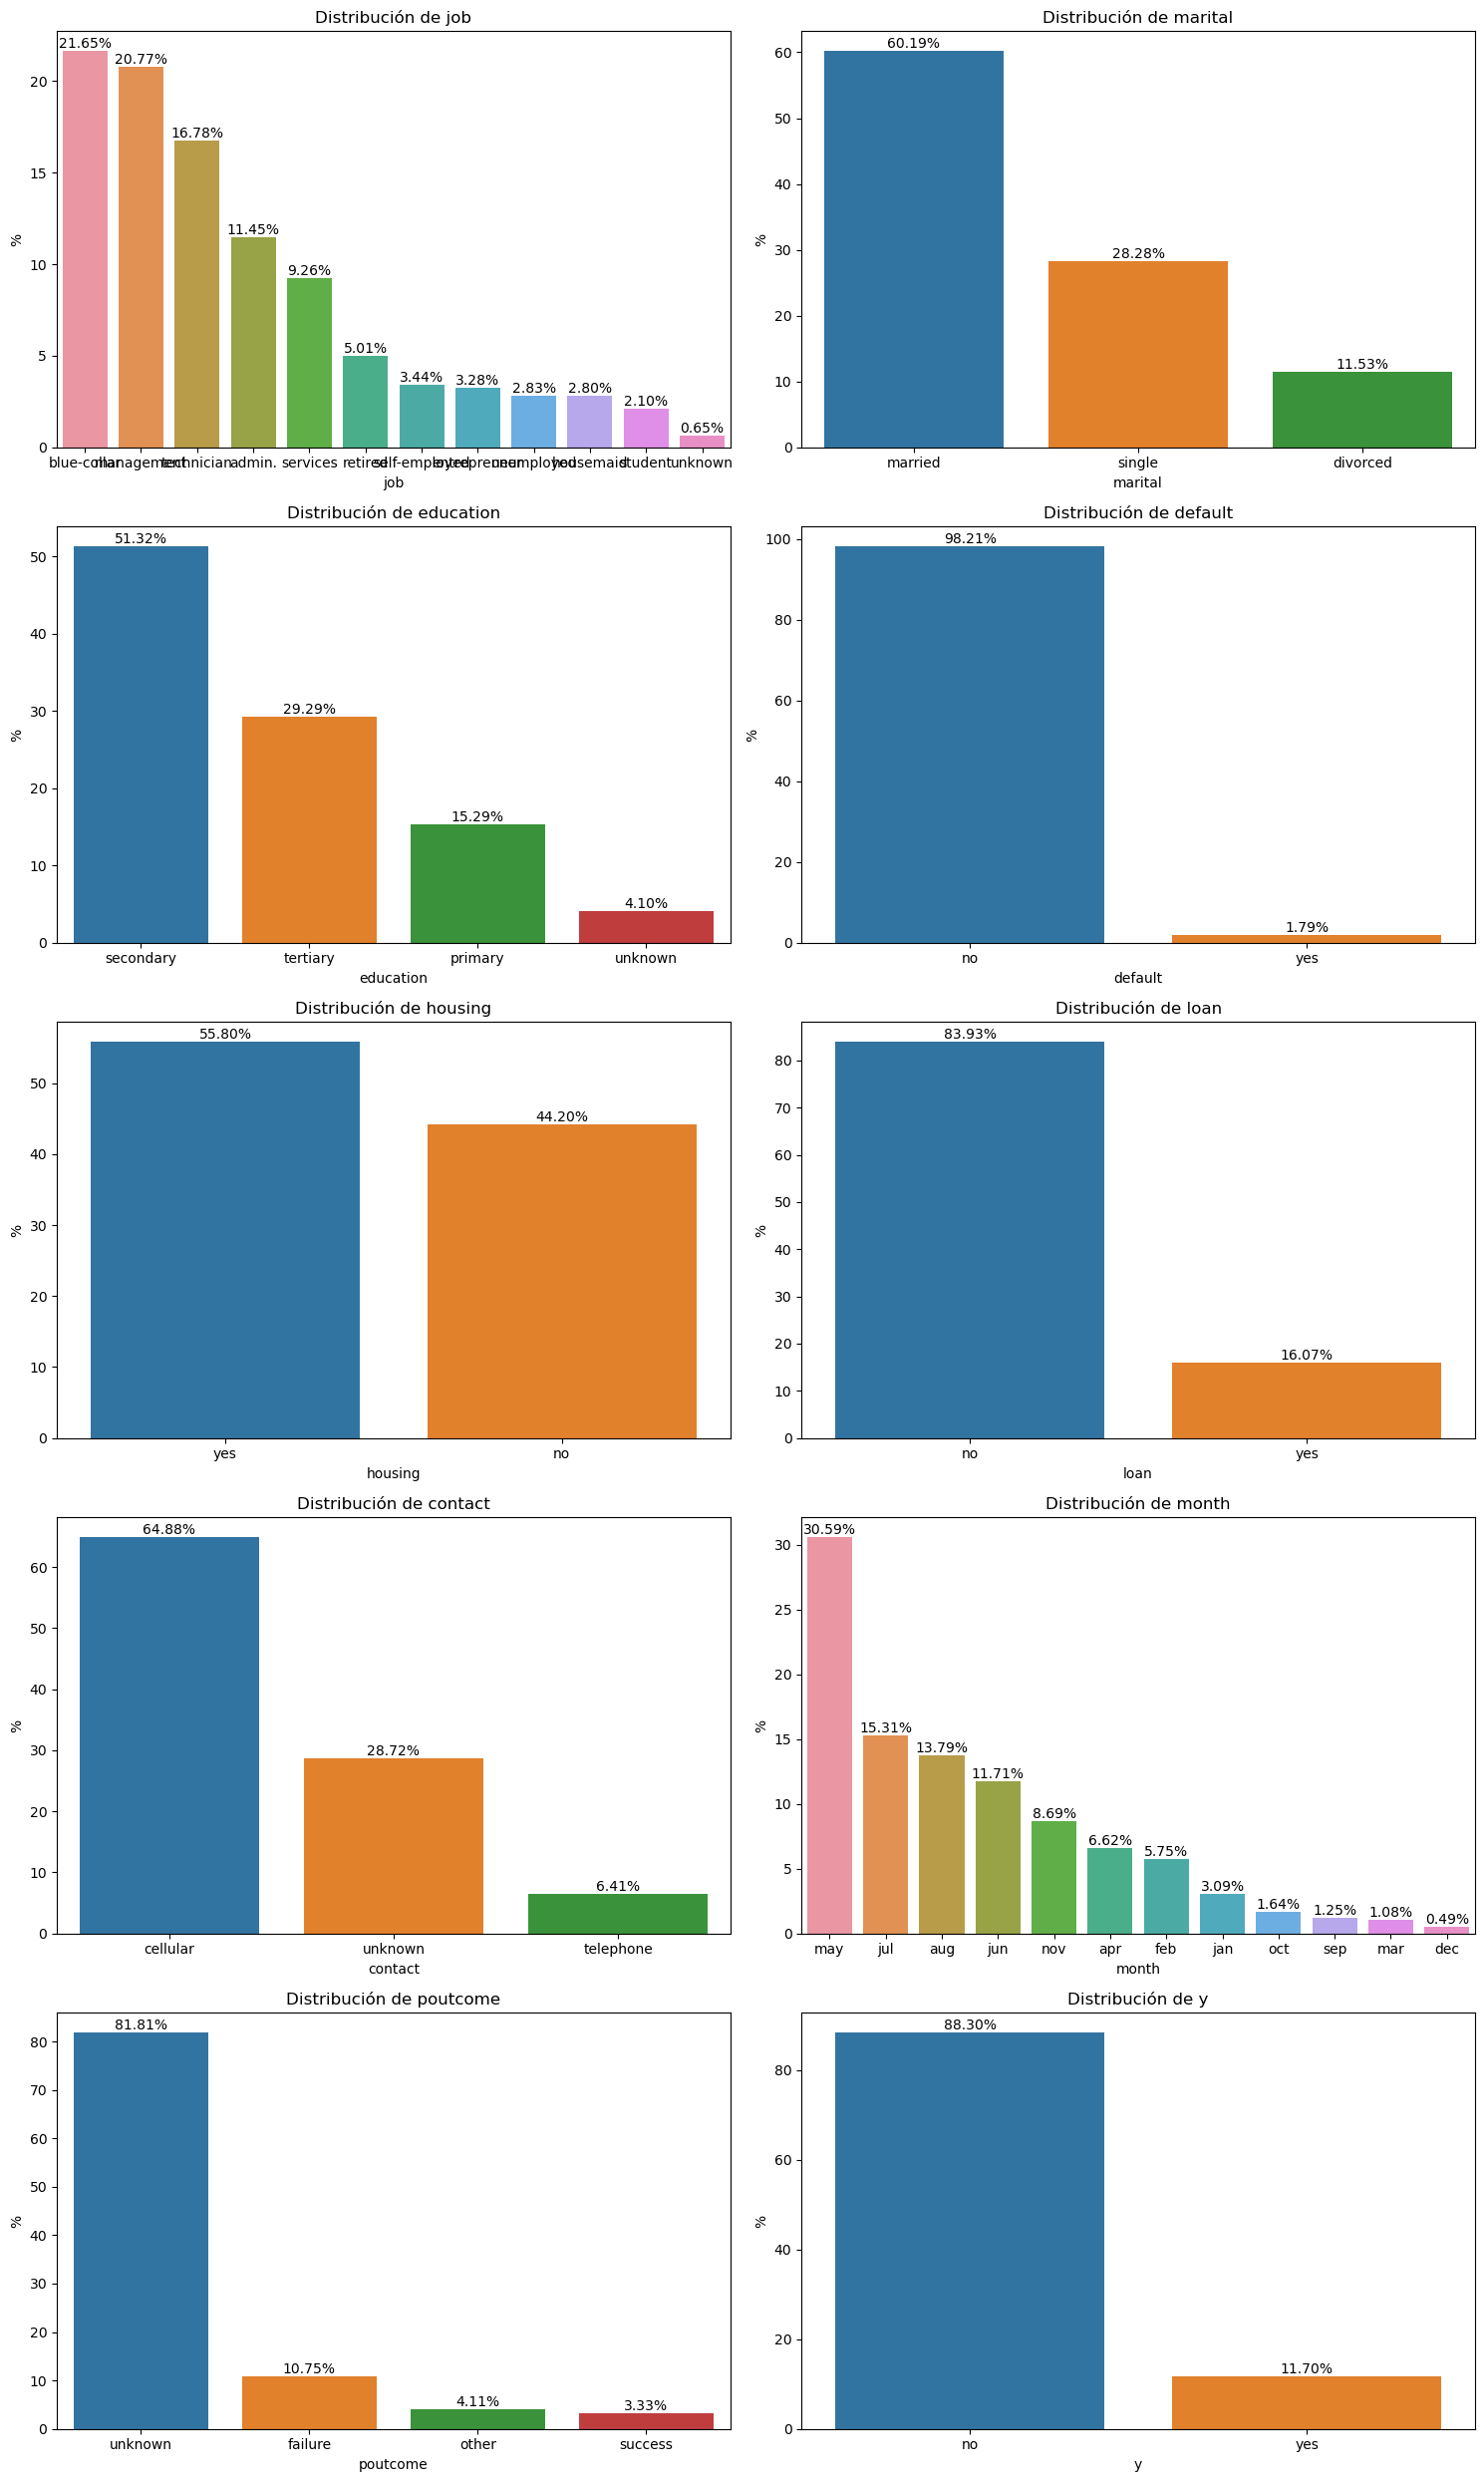

In [18]:
# Calcular el número de filas necesarias
num_rows = len(features_cat) // 2
if len(features_cat) % 2 != 0:
    num_rows += 1

# Crear subtramas
fig, axes = plt.subplots(nrows=num_rows, ncols=2, figsize=(15, 5*num_rows))

# Iterar sobre cada variable categórica y crear gráficos de barras
for i, variable in enumerate(features_cat):
    row = i // 2
    col = i % 2
    # Calcular porcentajes
    counts = train_set[variable].value_counts(normalize=True) * 100
    sns.barplot(x=counts.index, y=counts.values, ax=axes[row, col])
    axes[row, col].set_title(f'Distribución de {variable}')
    axes[row, col].set_ylabel('%')
    # Agregar porcentajes como etiquetas de texto en cada barra
    for idx, val in enumerate(counts.values):
        axes[row, col].text(idx, val, f'{val:.2f}%', ha='center', va='bottom')

# Ajustar diseño y mostrar gráficos
plt.tight_layout()
plt.show()

### Bivariable

In [19]:
# Numéricas
corr_matrix = train_set.corr(numeric_only=True)
corr_matrix['y_numeric'].sort_values(ascending=False)


y_numeric    1.000000
duration     0.396742
pdays        0.100703
previous     0.088847
balance      0.055025
age          0.024704
day         -0.026595
campaign    -0.071978
Name: y_numeric, dtype: float64

Parece ser que no hay correlación entre ellas.  
La más alta es `duration` con un 0.39. Si estableciéramos la regla que Hegoi comentó del 70/30, no entraría.  


c:\Users\Alfonso\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


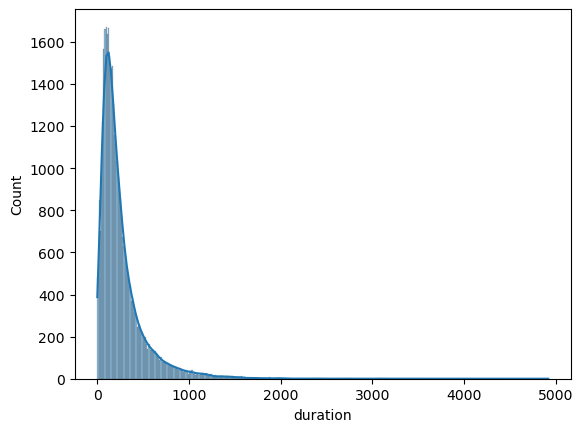

In [20]:
sns.histplot(x= 'duration', data = train_set, kde=True );

In [22]:
# CAtegóricas
features_cat_copy = features_cat.copy()
features_cat_copy.remove('y')
features_cat_copy


['job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'poutcome']

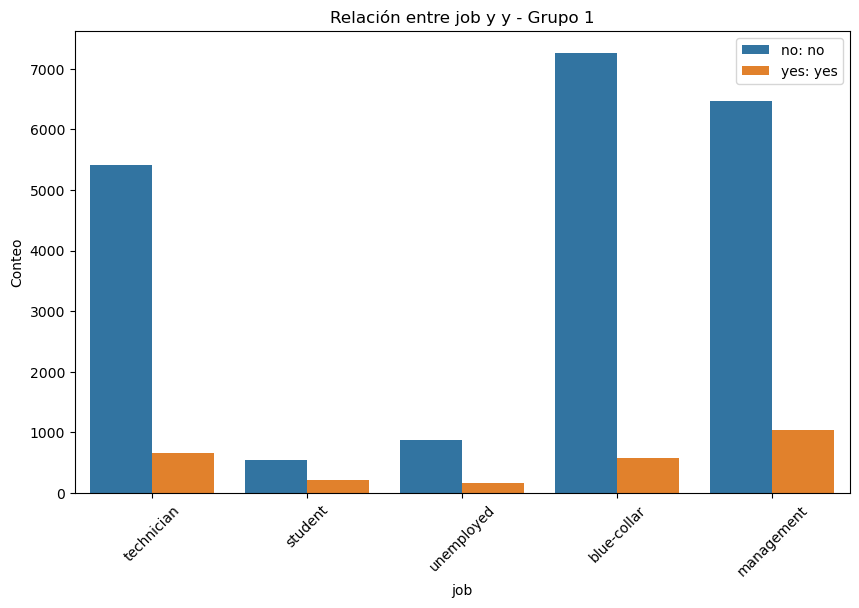

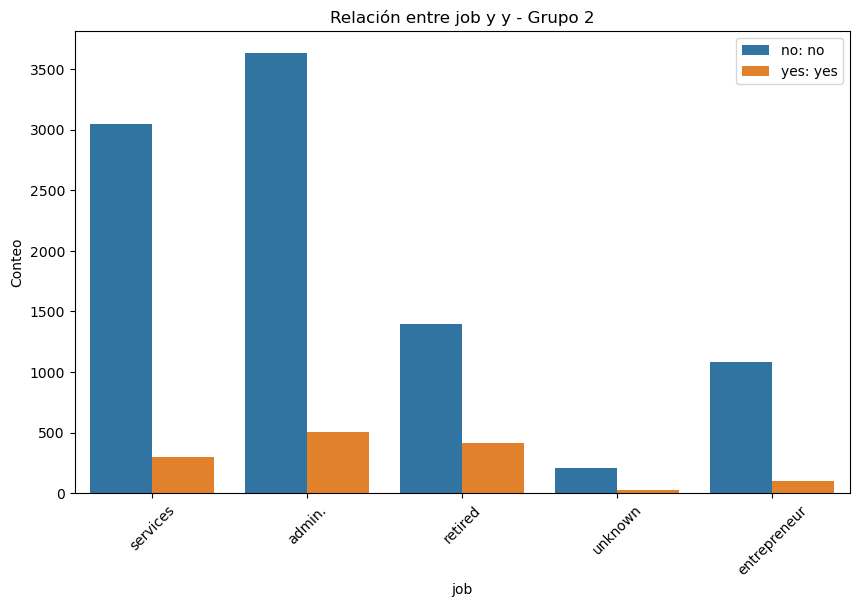

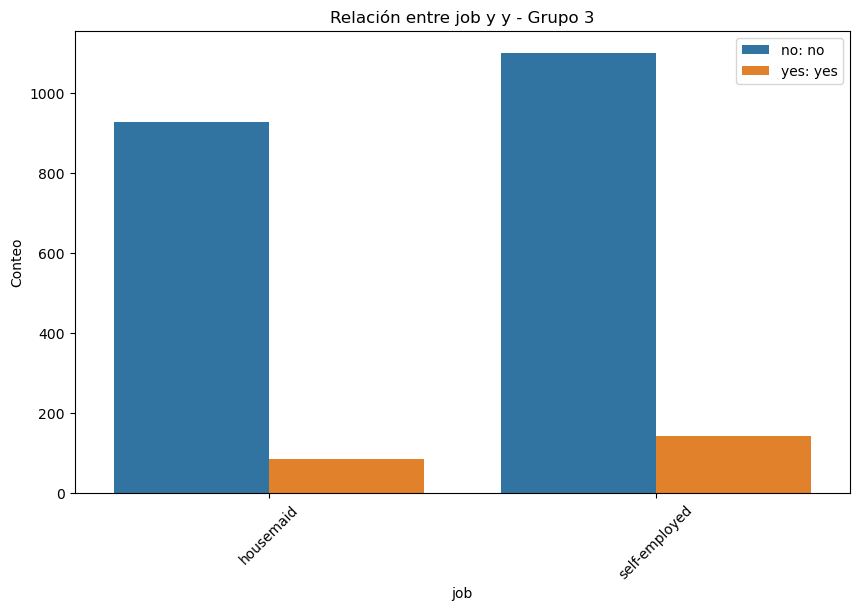

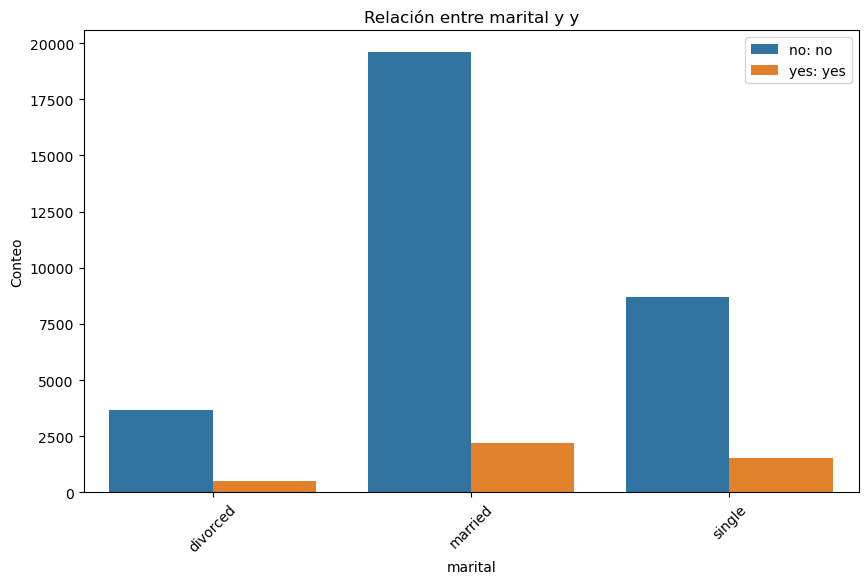

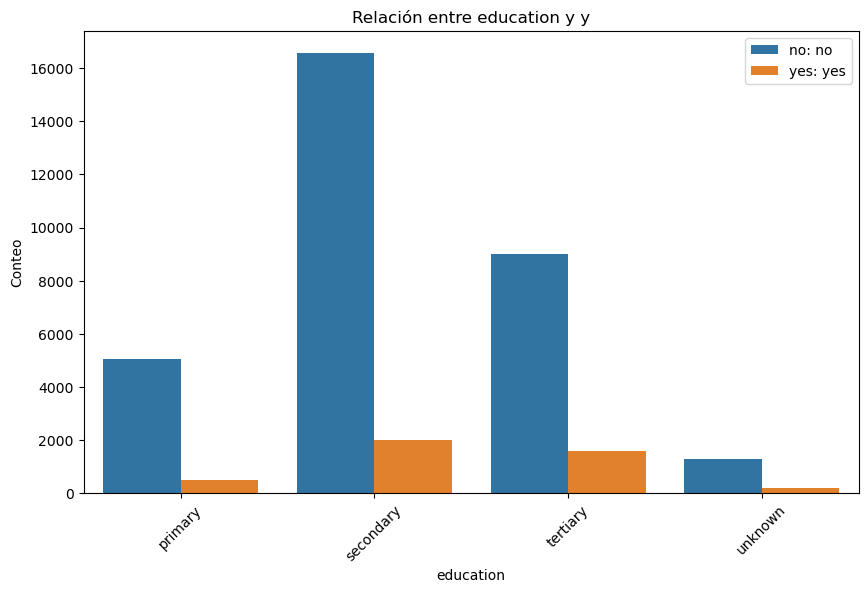

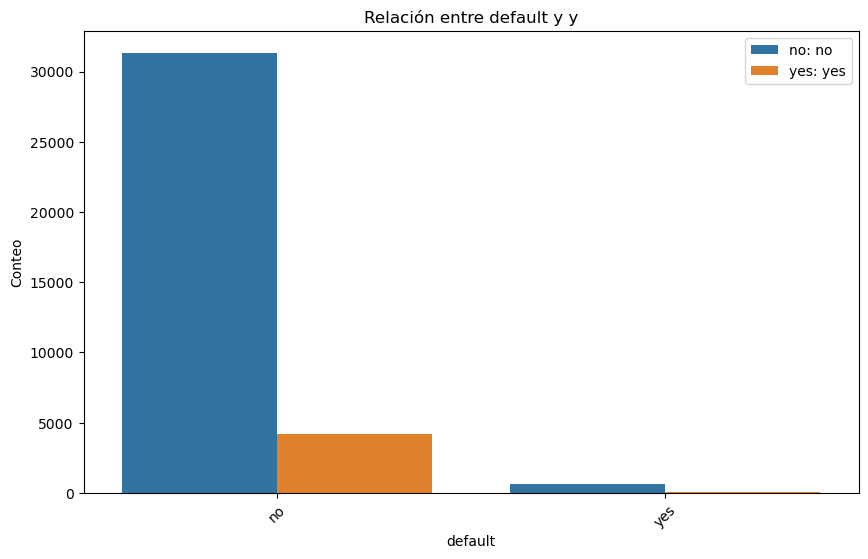

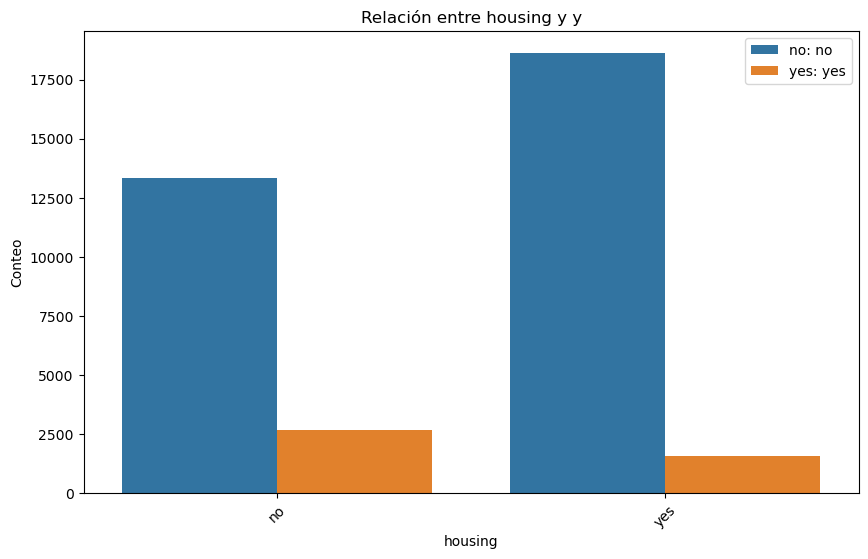

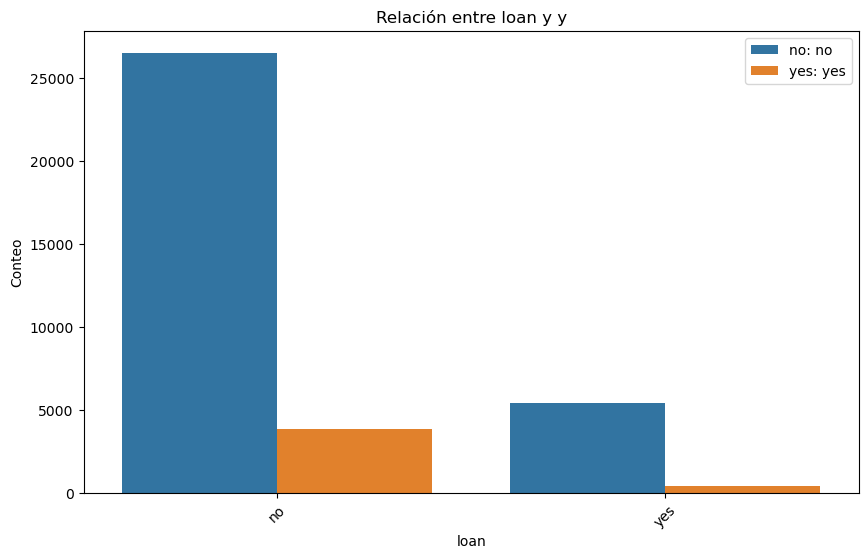

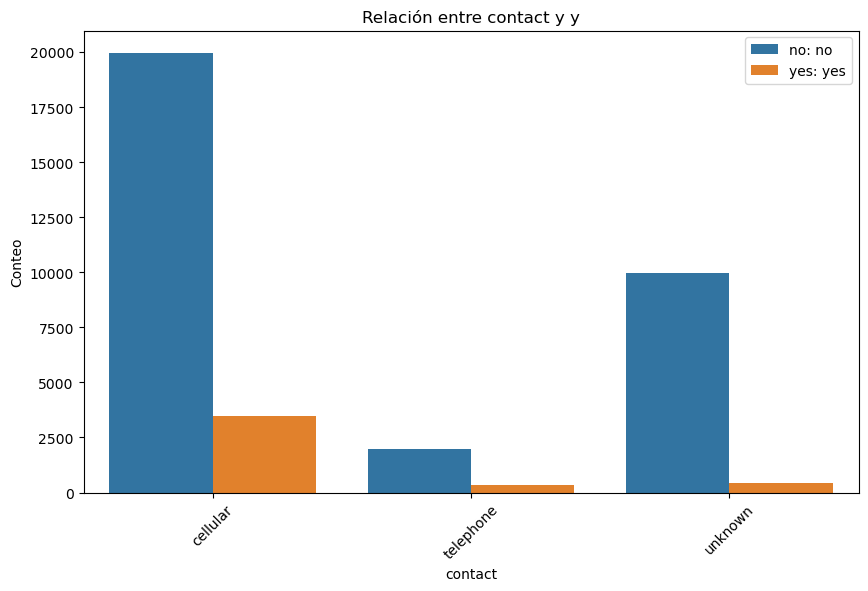

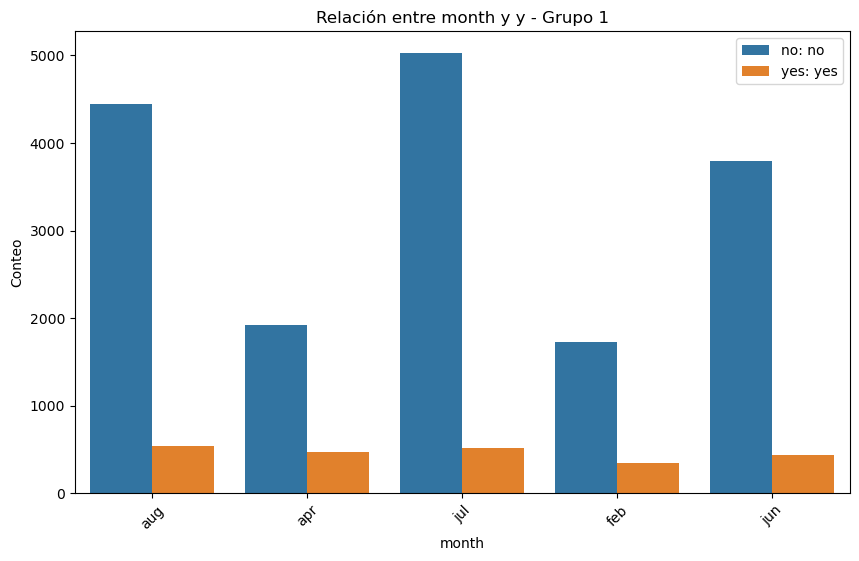

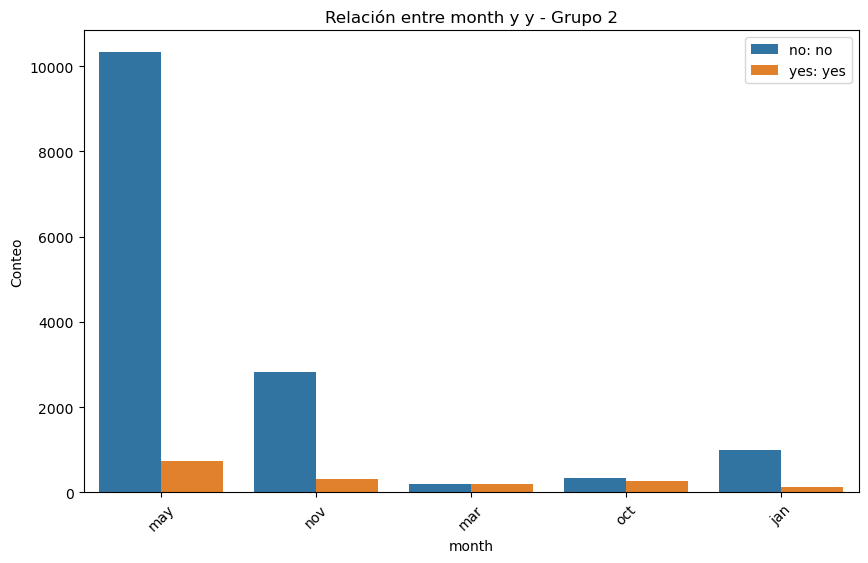

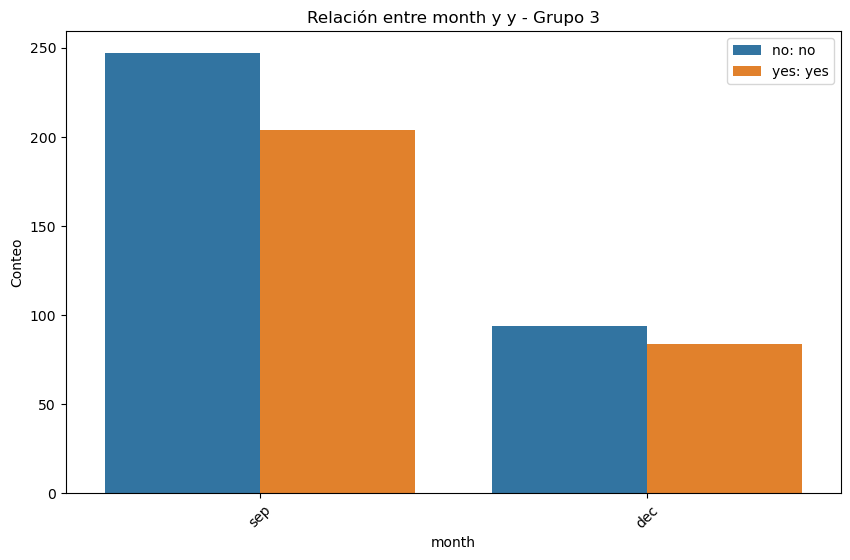

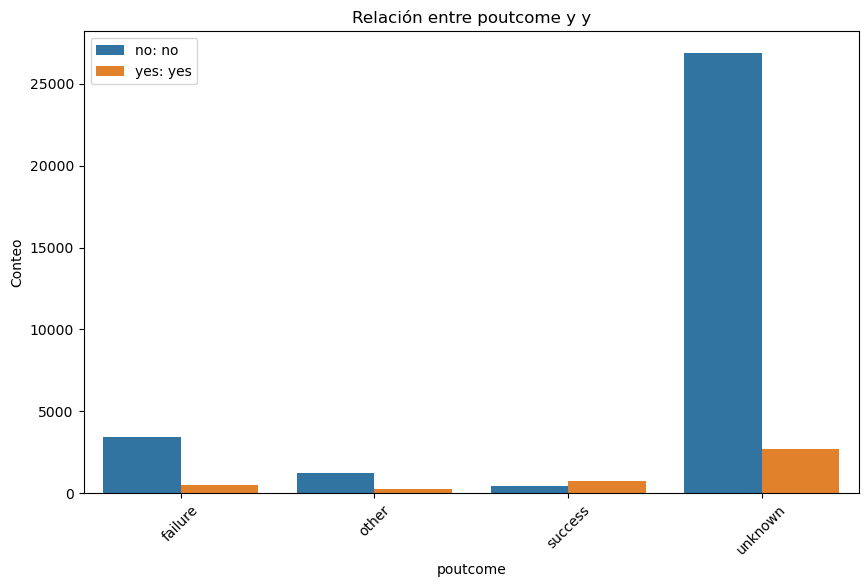

In [23]:
plot_categorical_relationship(train_set, features_cat_copy, 'y')

In [24]:
dic['loan']

'¿tiene préstamo personal? (binario: "sí", "no")'

Voy a coger todas las variables categóricas

## Tratamiento variables

In [25]:
# Categóricas
pd.get_dummies(train_set, columns=features_cat_copy, dtype = int)

,age,balance,day,duration,campaign,pdays,previous,y,y_numeric,job_admin.,...,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
24001,36,861,29,140,2,-1,0,no,0,0,...,0,0,0,0,0,0,0,0,0,1
43409,24,4126,5,907,4,185,7,yes,1,0,...,0,0,0,0,0,0,1,0,0,0
20669,44,244,12,1735,4,-1,0,yes,1,0,...,0,0,0,0,0,0,0,0,0,1
18810,48,0,31,35,11,-1,0,no,0,0,...,0,0,0,0,0,0,0,0,0,1
23130,38,257,26,57,10,-1,0,no,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17958,50,917,30,58,2,-1,0,no,0,0,...,0,0,0,0,0,0,0,0,0,1
15941,36,22,22,77,5,-1,0,no,0,1,...,0,0,0,0,0,0,0,0,0,1
16952,45,79,25,98,1,-1,0,no,0,0,...,0,0,0,0,0,0,0,0,0,1
34781,27,2559,6,227,1,-1,0,no,0,0,...,0,0,1,0,0,0,0,0,0,1


In [26]:
train_set = pd.get_dummies(train_set, columns=features_cat_copy, dtype = int)

In [27]:
train_set.columns

Index(['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous',
       'y', 'y_numeric', 'job_admin.', 'job_blue-collar', 'job_entrepreneur',
       'job_housemaid', 'job_management', 'job_retired', 'job_self-employed',
       'job_services', 'job_student', 'job_technician', 'job_unemployed',
       'job_unknown', 'marital_divorced', 'marital_married', 'marital_single',
       'education_primary', 'education_secondary', 'education_tertiary',
       'education_unknown', 'default_no', 'default_yes', 'housing_no',
       'housing_yes', 'loan_no', 'loan_yes', 'contact_cellular',
       'contact_telephone', 'contact_unknown', 'month_apr', 'month_aug',
       'month_dec', 'month_feb', 'month_jan', 'month_jul', 'month_jun',
       'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep',
       'poutcome_failure', 'poutcome_other', 'poutcome_success',
       'poutcome_unknown'],
      dtype='object')

## X,y para modelo

In [28]:
columnas_eliminar = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous','y','y_numeric']

X_train = train_set.drop(columnas_eliminar,axis = 1)
y_train = train_set['y_numeric']
print(X_train.shape)
print(y_train.shape)



(36168, 44)
(36168,)


In [29]:
tree = DecisionTreeClassifier()
tree.fit(X_train,y_train)

DecisionTreeClassifier()

In [30]:
log_reg = LogisticRegression()
log_reg.fit(X_train,y_train)

LogisticRegression()

In [31]:
print(log_reg.coef_)
print(log_reg.intercept_)
print(log_reg.classes_)

[[ 0.02556299 -0.10359757 -0.15624729 -0.31936163 -0.01833904  0.48940892
  -0.12718004 -0.0697298   0.33121295 -0.05057871  0.12229466 -0.12286987
   0.05188641 -0.18282883  0.13151799 -0.1527241   0.00428205  0.15089062
  -0.00187301  0.12603792 -0.12546235  0.26817551 -0.26759994  0.19480973
  -0.19423416  0.51720309  0.30022302 -0.81685054  0.13862182 -0.84106275
   0.72542216 -0.28780516 -0.92790923 -0.65236198  0.25272741  1.13048055
  -0.39056737 -0.70773576  0.79032019  0.7704457  -0.6539029  -0.38757877
   1.62831253 -0.58625528]]
[-1.76212097]
[0 1]


## Procesamiento DataSet Test

In [32]:
test_set['y_numeric'] = test_set['y'].map({'no': 0, 'yes': 1})
test_set = pd.get_dummies(test_set, columns=features_cat_copy, dtype = int)

In [33]:
columnas_eliminar = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous','y','y_numeric']

X_test = test_set.drop(columnas_eliminar,axis = 1)
y_test = test_set['y_numeric']
print(X_test.shape)
print(y_test.shape)

(9043, 44)
(9043,)


## Comparación entre modelos

In [34]:
# classification_report para árbol de decisión para clasificación
print(classification_report(y_test,tree.predict(X_test)))

              precision    recall  f1-score   support

           0       0.90      0.97      0.93      7985
           1       0.46      0.21      0.29      1058

    accuracy                           0.88      9043
   macro avg       0.68      0.59      0.61      9043
weighted avg       0.85      0.88      0.86      9043



In [35]:
# classification_report regresión
print(classification_report(y_test, log_reg.predict(X_test)))

              precision    recall  f1-score   support

           0       0.90      0.99      0.94      7985
           1       0.67      0.18      0.29      1058

    accuracy                           0.89      9043
   macro avg       0.78      0.59      0.61      9043
weighted avg       0.87      0.89      0.87      9043



Parece que son modelos muy similares (sin haber tocado nada)

## Optimización hiperparámetros

### Random

Para el árbol de decisión

In [36]:
# Para el árbol de decisión de clasificación
param_grid_decision_tree = {
    'max_depth': [3, 5, 7],  # Profundidad máxima del árbol
    'min_samples_split': [2, 5, 7, 10],  # Número mínimo de muestras requeridas para dividir un nodo interno
    'min_samples_leaf': [2, 4, 6,9 ]} # Número mínimo de muestras requeridas para estar en un nodo hoja
    #'max_features': ['auto', 'sqrt', 'log2'], # Limitar número de características tratando de optimizar el modelo
    #'class_weight': [None, 'balanced', {0: 1, 1: 2}, {0: 1, 1: 5}]} # Viene bien al tener clases desbalanceadas

In [37]:
# Árboles de decisión

# Crear la instancia de RandomizedSearchCV
random_search_tree = RandomizedSearchCV(estimator=tree,
                                            param_distributions=param_grid_decision_tree,
                                            scoring="neg_root_mean_squared_error",
                                            cv=5,
                                            n_iter=100,  # Número de combinaciones de hiperparámetros a probar
                                            random_state=1,
                                            n_jobs=-1)

# Realizar la búsqueda aleatoria en el espacio de hiperparámetros
random_search_tree.fit(X_train, y_train)

c:\Users\Alfonso\miniconda3\Lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 48 is smaller than n_iter=100. Running 48 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


RandomizedSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'max_depth': [3, 5, 7],
                                        'min_samples_leaf': [2, 4, 6, 9],
                                        'min_samples_split': [2, 5, 7, 10]},
                   random_state=1, scoring='neg_root_mean_squared_error')

In [38]:
random_search_tree.best_params_

{'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 3}

In [39]:
random_search_tree.best_score_**2

0.10705377907630494

In [40]:
random_search_tree.best_estimator_

DecisionTreeClassifier(max_depth=3, min_samples_leaf=2)

In [41]:
random_search_tree.best_estimator_.score(X_test,y_test)

0.8930664602454937

In [42]:
print(classification_report(y_test, random_search_tree.predict(X_test)))

              precision    recall  f1-score   support

           0       0.90      0.99      0.94      7985
           1       0.66      0.18      0.28      1058

    accuracy                           0.89      9043
   macro avg       0.78      0.58      0.61      9043
weighted avg       0.87      0.89      0.86      9043



Para la regresión logística

In [43]:
param_grid_logistic = {
    #'penalty': ['l1', 'l2'],  # Tipo de regularización
    'C': [0.001, 0.01, 0.1, 1, 10],  # Valores para regularización
    'solver': ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'],  # Algoritmos de optimización
    'max_iter': [100, 200, 300, 400]  # Número máximo de iteraciones
}

In [44]:
# Crear la instancia de RandomizedSearchCV
random_search_logistic = RandomizedSearchCV(estimator=log_reg,
                                            param_distributions=param_grid_logistic,
                                            scoring="neg_root_mean_squared_error",
                                            cv=5,
                                            n_iter=100,  # Número de combinaciones de hiperparámetros a probar
                                            random_state=1,
                                            n_jobs=-1)

# Realizar la búsqueda aleatoria en el espacio de hiperparámetros
random_search_logistic.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=LogisticRegression(), n_iter=100, n_jobs=-1,
                   param_distributions={'C': [0.001, 0.01, 0.1, 1, 10],
                                        'max_iter': [100, 200, 300, 400],
                                        'solver': ['liblinear', 'newton-cg',
                                                   'lbfgs', 'sag', 'saga']},
                   random_state=1, scoring='neg_root_mean_squared_error')

In [45]:
random_search_logistic.best_params_

{'solver': 'liblinear', 'max_iter': 100, 'C': 0.1}

In [46]:
random_search_logistic.best_score_**2

0.10768602632042092

In [47]:
random_search_logistic.best_estimator_

LogisticRegression(C=0.1, solver='liblinear')

In [48]:
random_search_logistic.best_estimator_.coef_

array([[-0.01667106, -0.15392799, -0.18846285, -0.32434605, -0.0609625 ,
         0.43838765, -0.16000665, -0.11538502,  0.27663643, -0.0970214 ,
         0.07035466, -0.11769659, -0.09916513, -0.33239573, -0.01754051,
        -0.26299317, -0.11208867,  0.03425738, -0.10827691, -0.13247257,
        -0.31662879,  0.04600413, -0.4951055 , -0.03055438, -0.41854698,
         0.35047712,  0.13764844, -0.93722692,  0.11904505, -0.83526806,
         0.57042848, -0.29324464, -0.86294526, -0.65126379,  0.20465752,
         1.00835952, -0.41080801, -0.6988796 ,  0.71738076,  0.68343667,
        -0.74102941, -0.4682222 ,  1.4658933 , -0.70574306]])

In [49]:
random_search_logistic.best_estimator_.score(X_test,y_test)

0.893177043016698

In [50]:
print(classification_report(y_test, random_search_logistic.predict(X_test)))

              precision    recall  f1-score   support

           0       0.90      0.99      0.94      7985
           1       0.67      0.17      0.27      1058

    accuracy                           0.89      9043
   macro avg       0.78      0.58      0.61      9043
weighted avg       0.87      0.89      0.86      9043



### Búsqueda completa

In [51]:
# Búsqueda completa para el árbol de decisión por clasificación
grid_search_tree = GridSearchCV(tree,
                           param_grid_decision_tree,
                           cv=5,
                           scoring='r2',
                           n_jobs=-1
                          )

grid_search_tree.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'max_depth': [3, 5, 7],
                         'min_samples_leaf': [2, 4, 6, 9],
                         'min_samples_split': [2, 5, 7, 10]},
             scoring='r2')

In [52]:
grid_search_tree.best_params_

{'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 2}

In [53]:
grid_search_tree.best_score_

-0.036389429946263444

In [54]:
grid_search_tree.best_estimator_.score(X_test,y_test)

0.8930664602454937

In [55]:
print(classification_report(y_test, grid_search_tree.predict(X_test)))

              precision    recall  f1-score   support

           0       0.90      0.99      0.94      7985
           1       0.66      0.18      0.28      1058

    accuracy                           0.89      9043
   macro avg       0.78      0.58      0.61      9043
weighted avg       0.87      0.89      0.86      9043



In [56]:
# Búsqueda completa para la regresión
grid_search_log = GridSearchCV(log_reg,
                           param_grid_logistic,
                           cv=5,
                           scoring='r2',
                           n_jobs=-1
                          )

grid_search_log.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10],
                         'max_iter': [100, 200, 300, 400],
                         'solver': ['liblinear', 'newton-cg', 'lbfgs', 'sag',
                                    'saga']},
             scoring='r2')

In [57]:
grid_search_log.best_params_

{'C': 0.1, 'max_iter': 100, 'solver': 'liblinear'}

In [58]:
grid_search_log.best_score_

-0.04254211789319089

In [59]:
grid_search_log.best_estimator_.score(X_test,y_test)

0.893177043016698

In [60]:
print(classification_report(y_test, grid_search_log.predict(X_test)))

              precision    recall  f1-score   support

           0       0.90      0.99      0.94      7985
           1       0.67      0.17      0.27      1058

    accuracy                           0.89      9043
   macro avg       0.78      0.58      0.61      9043
weighted avg       0.87      0.89      0.86      9043



random_search_tree.best_estimator_.score(X_test,y_test): 0.8930664602454937  
random_search_logistic.best_estimator_.score(X_test,y_test): 0.893177043016698  
grid_search_tree.best_estimator_.score(X_test,y_test): 0.8930664602454937  
grid_search_log.best_estimator_.score(X_test,y_test): 0.893177043016698  

Pues me salen igual!!!... entiendo que es porque el aleatorio ha cogido unos hiperparámetros ideales que posteriormente ha validado la búsqueda completa?